# 5SSG2060 Practical Week 10 :  Multivariate Regression & Spatial Regression
<a href="#This Week's Overview">This Week's Overview</a>
 
 <a href="#Learn Outcomes">Learn Outcomes</a> 
 
 <a href='#Get organized'>Get organized</a>
- <a href='#Import libraries'>Import libraries</a>
- <a href='#Prepare data'>Prepare data</a>

<a href='#Aspatial Multivariate Regression'>Aspatial Multivariate Regression</a>


<a href='#Spatial Regression'>Spatial Regression</a>
  - <a href='#Spatial Lag model'>Spatial Lag model<a/>
  - <a href='#Spatial Error model'>Spatial Error model<a/>
  - <a href='#Prediction performance of spatial models'>Prediction performance of spatial models</a>
  - <a href='#GWR Prediction'>GWR Prediction<a/>

# <a id="This Week's Overview">This Week's Overview</a>
This week, we will mainly use `PySAL` and `Numpy` to realize both nonspatial and spatial regression purposes. The spatial regression models will be introduced with both Spatial Lag model and Spatial Error model for your comparison, and GWR (geographical weighted regression) prediction will also follow as the end of this practical. 

# <a id="Learn Outcomes">Learn Outcomes</a>
By the end of this practical, you would be able to conduct and interpret
- Aspatial Multivariate Regression Model
- Spatial Lag Model
- Spatial Error Model

And be able to do corresponding prediction using geographical weighted regression model.

# <a id='Get organized'>Get organized</a>
## <a id='Import libraries'>Import libraries</a>

In [1]:
import os
import urllib
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

import pysal as ps
from pysal.spreg import ols
from pysal.spreg import ml_error
from pysal.spreg import ml_lag

import seaborn as sns
sns.set(style="whitegrid")

## <a id='Prepare data'>Prepare data</a>
Please copy the **shapefile data "borough_airbnb_housing"** we produced last week into your "data" folder for this week.

In [2]:
# read in your data and get the headers presented
gdf=gpd.read_file('data/borough_airbnb_housing.shp')
gdf.head()

,Borough,Sector,Population,Households,Dwellings,person_dwe,house_stoc,house_st_1,net_homes,private_re,house_pric,earnings,ratio_pric,price,number_of_,Number of,geometry
0,Kingston upon Thames,Outer,173703,70175,66410,2.6,0.02,7420,273,1300,484965,37865.0,16,76.486755,6.652318,302,POLYGON ((-0.3306936415070752 51.3290679022793...
1,Croydon,Outer,383301,156027,152520,2.5,0.05,26510,2835,1100,372024,33821.0,11,56.668085,6.176596,470,POLYGON ((-0.0640409250229735 51.3186954126904...
2,Bromley,Outer,327580,137972,136860,2.4,0.02,18950,858,1150,445387,40490.0,15,62.375000,6.350610,328,POLYGON ((0.01210989689387686 51.2996573924981...
3,Hounslow,Outer,268270,104711,98790,2.7,0.04,26650,557,1300,407680,31764.0,11,88.089701,11.740864,602,POLYGON ((-0.2445796318688628 51.4887559775884...
4,Ealing,Outer,344802,130659,130530,2.6,0.03,23950,845,1400,481834,32991.0,16,90.856140,11.069006,855,POLYGON ((-0.4118469484208172 51.5341363235970...


Since the labels changed as expected (10 letters limit, remember?), we need to rename them back into some human language again.

In [3]:
#change column names here. 
cnames = {'Borough' : 'borough', 
          'Sector' : 'sector', 
          'Population': 'population', 
          'Households' : 'households', 
          'Dwellings' : 'dwellings', 
          'person_dwe' : 'per_dwell', 
          'house_stoc' : 'house_growth', 
          'house_st_1' : 'house_stock',
          'net_homes' : 'net_home', 
          'private_re': 'private_rent_price',
          'house_pric': 'house_price',
          'ratio_pric': 'ratio_price_earn',
          'price': 'listing_price',
          'number_of_': 'reviews',
          'Number of': 'airbnb_amount',
          'geometry': 'geometry' 
         }
gdf.rename(columns=cnames, inplace=True)

In [4]:
gdf.head()

,borough,sector,population,households,dwellings,per_dwell,house_growth,house_stock,net_home,private_rent_price,house_price,earnings,ratio_price_earn,listing_price,reviews,airbnb_amount,geometry
0,Kingston upon Thames,Outer,173703,70175,66410,2.6,0.02,7420,273,1300,484965,37865.0,16,76.486755,6.652318,302,POLYGON ((-0.3306936415070752 51.3290679022793...
1,Croydon,Outer,383301,156027,152520,2.5,0.05,26510,2835,1100,372024,33821.0,11,56.668085,6.176596,470,POLYGON ((-0.0640409250229735 51.3186954126904...
2,Bromley,Outer,327580,137972,136860,2.4,0.02,18950,858,1150,445387,40490.0,15,62.375000,6.350610,328,POLYGON ((0.01210989689387686 51.2996573924981...
3,Hounslow,Outer,268270,104711,98790,2.7,0.04,26650,557,1300,407680,31764.0,11,88.089701,11.740864,602,POLYGON ((-0.2445796318688628 51.4887559775884...
4,Ealing,Outer,344802,130659,130530,2.6,0.03,23950,845,1400,481834,32991.0,16,90.856140,11.069006,855,POLYGON ((-0.4118469484208172 51.5341363235970...


# <a id='Aspatial Multivariate Regression'>Aspatial Multivariate Regression<a/>
We will use `PySAL` to analyse the relations between `Airbnb listing price` and other housing and earning variables by borough in London. Before introducing explicitly spatial methods next week, we will run a simple ordinary least squares (OLS) linear regression model to analyze the relationship between these variables. Hence providing us the capability to interpret regression results on which the spatial models will build on; and enabling us to evaluate the meaningfulness of spatial regression models upon comparions. 

Normally, an OLS linear regression is to explain a given variable $y$, as a linear function of a set of other variables $X$:

$y_i$=α+β$X_i$+$ϵ_i$

where $i$ is the boroughs in our example, and $\epsilon_i$ is the error term for our probabilistic model. 

Now let's start with read in the dependent variable $y$ and independent variables $X$:

We will start directly with more than 3 independant variables for today, but if in your own project, the X is a 2 dimensional array, which means only 2 independant variables, then the ordinary least squares (OLS) regression is performed with [pysal.spreg](https://pysal.readthedocs.io/en/v1.11.0/library/spreg/index.html), with outputs callable through its `summary` feature and I leave more to explore by yourself. 

In [5]:
# read the .dbf file from your shapefile data
f = ps.open('data/borough_airbnb_housing.dbf','r')
# Read in the listing_price (dependent variable) into an array y
y = np.array(f.by_col['price'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(f.by_col['number_of_']) # number_of_reviews
X.append(f.by_col['private_re']) # private_rent_price
X.append(f.by_col['ratio_pric']) # ratio_price_earning
X.append(f.by_col['person_dwe']) # person_dwelling
X = np.array(X).T

In [6]:
m1 = ols.OLS(y, X, name_y = 'price', name_x = ['number_of_reviews', 'private_rent','ratio_price_earning', 'person_dwelling'], name_ds = 'borough_airbnb_housing')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :borough_airbnb_housing
Weights matrix      :        None
Dependent Variable  :       price                Number of Observations:          33
Mean dependent var  :     84.0398                Number of Variables   :           5
S.D. dependent var  :     31.3432                Degrees of Freedom    :          28
R-squared           :      0.8389
Adjusted R-squared  :      0.8159
Sum squared residual:    5064.459                F-statistic           :     36.4513
Sigma-square        :     180.874                Prob(F-statistic)     :   1.011e-10
S.E. of regression  :      13.449                Log likelihood        :    -129.878
Sigma-square ML     :     153.468                Akaike info criterion :     269.755
S.E of regression ML:     12.3882                Schwarz criterion     :     277.238

-------------------------------------------------------------------

### <a id="Task 1">Task 1<a/>
Interpret the regression summary, and get your answers to:
- Is current OLS model well enough? What is the adjusted R-squared value and how to interpret it?
- Which variable(s) have significant influence on airbnb listing price, and how they are going to affect the pricing?
- Which are the parameters telling us the model fit?
- Is multicollinearity existing? If so, do you have better solutions? If you are going to replace some variables for improvement, which variables will be considered?

However, you may already found this method is not good enough! We call the array by using pysal wrapper $f$, so we can only define **X** with the original cutted labels for variables, which is not easy to interpret. How if we want to keep using the geodataframe to do the regression? We can use `statsmodels` (you've seen it last week in optional section) to realize the function.

In [7]:
import statsmodels.api as sm
x = ['airbnb_amount', 'private_rent_price', 'ratio_price_earn', 'per_dwell'] # define input/independant variables
X = gdf.loc[:, x].dropna()
y = np.array(gdf['listing_price']) # define output/dependant variable
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     371.9
Date:                Wed, 13 Mar 2019   Prob (F-statistic):           1.84e-24
Time:                        11:30:51   Log-Likelihood:                -129.86
No. Observations:                  33   AIC:                             267.7
Df Residuals:                      29   BIC:                             273.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
airbnb_amount         -0.0062      0.002     -2.974      0.006      -0.011      -0.002
private_rent_price     0.1103      0.013      8.598      0.000       0.084       0.137
ratio_price_earn      -1.8474      0.807     -2.290      0.029      -3.497      -0.198
per_dwell            -15.3602      3.133     -4.903      0.000     -21.767      -8.954
==============================================================================
Omnibus:                        3.716   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.316
Skew:                           0.460   Prob(JB):                        0.314
Kurtosis:                       3.915   Cond. No.                     3.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What have you got this time? The output summary is very different from the previous one.

"Ordinary Least Squares (OLS)" method means that we’re trying to fit a regression line that would minimize the square of distance from the regression line. Date and Time are the precise moment you got this summary, Number of observations is the count of rows, and in our dataset it equals to the number of boroughs. $Df$ of residuals and models relates to the degrees of freedom ("number of values in the final calculation of a statistic that are free to vary").

Take the private_rent_price variable as an example, the coefficient of 0.1103 means that as the private rent price increases by 1, the predicted value of airbnb listing price increases by 11%. Similar explanations could be made on other coefficients with a signifant $p$ value.

Other important measures include: 

- R-squared: how much percentage of variance the model can explain; 
Std err (standard error): standard deviation of the sampling distribution of a statistic, e.g. mean; 

- t scores and p-values: hypothesis test. If private_rent_price variable has statistically significant p-value; there is a 95% confidence intervals for it.

If we want to add a constant intercept to the model, we can call the following:

In [8]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model_c = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model_c.predict(X)

# Print out the statistics
model_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     38.99
Date:                Wed, 13 Mar 2019   Prob (F-statistic):           4.61e-11
Time:                        11:31:15   Log-Likelihood:                -128.94
No. Observations:                  33   AIC:                             267.9
Df Residuals:                      28   BIC:                             275.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 47.1647     37.345      1.263      0.217     -29.332     123.662
airbnb_amount         -0.0045      0.003     -1.786      0.085      -0.010       0.001
private_rent_price     0.0909      0.020      4.558      0.000       0.050       0.132
ratio_price_earn      -1.4474      0.859     -1.685      0.103      -3.207       0.312
per_dwell            -26.4548      9.316     -2.840      0.008     -45.538      -7.372
==============================================================================
Omnibus:                        3.078   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.098
Skew:                           0.609   Prob(JB):                        0.350
Kurtosis:                       3.202   Cond. No.                     4.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With the constant term the coefficients are different now. The previous model without constant term, we forced our model to go through the origin data, but now we have a y-intercept at 47.1647, the slope of the private rent price variable also decreased from 0.11 to 0.09.

The model explanation capability decreased from 98.1% of the variance in dependent variable, airbnb listing price, to 84.8%, reading from the R-squared values of summaries. Think of another scenario, how if we add other variables to this regression model, will the R² get higher? Discuss with your neighbours if you want to share your opinion.

We can see both "private rent price" and "average persons living in each dwelling" are statistically significant in predicting (or estimating) the airbnb listing price. As the private rent price increases by 1, the airbnb listing price will increase by 0.09, which is almost 10 times relationship; when number of people living in each dwelling increases by 1 (people), the airbnb listing price will drop by 26.45 (sterlings). However, with an added constant, the number of airbnbs in borough begun to be insignificant in predicting the price.

In all, `Statsmodels` is functionally sufficient to conduct multivariate regression, and you can add up to 13 variables for your research！In addition, it also provide follow-on methods to diagnose your regression result.

### <a id='Regression diagnostics'>Regression diagnostics<a/>

The rationale is to check the normality of the residuals from our model. The meanings of statistics could be googled or discuss with your neighbors in class.

In [9]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
# Omni test
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(model.resid)
lzip(name, test)

[('Chi^2', 3.716198441749615), ('Two-tail probability', 0.1559688110520213)]

In [10]:
# Jarque-Bera test
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
lzip(name, test)

[('Jarque-Bera', 2.3155781117708965),
 ('Chi^2 two-tail prob.', 0.3141800480773652),
 ('Skew', 0.4600039554030429),
 ('Kurtosis', 3.915227978492175)]

In [11]:
# Multicollinearity on condition number
np.linalg.cond(model.model.exog)

3375.3470235464747

In [12]:
# Heteroskedasticity tests
# Breush-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 14.66193202715912),
 ('p-value', 0.0021295740146988),
 ('f-value', 5.796630667654575),
 ('f p-value', 0.001485544503297444)]

In [13]:
# Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 3.788498340007592), ('p-value', 0.01204056302795494)]

### <a id='Partial Regression Plots'>Partial Regression Plots<a/>
Partial regression plots show us the relationships between each independent variable and dependent varaiable individually, with a linear fit line added. However, you may find partical regression take natural log transformed data as default variables, the axis is with $ e(X) $ specification, and the scales for axis had changed even with negative values. But for our analysis, we didn't do data transformation beforehand for consistence, hence the axis have changed into Xth power of e. It doesn't affect the result for this practical, we only take it as an additional supportive part, helping you better interpret your regression summary intuitively. 

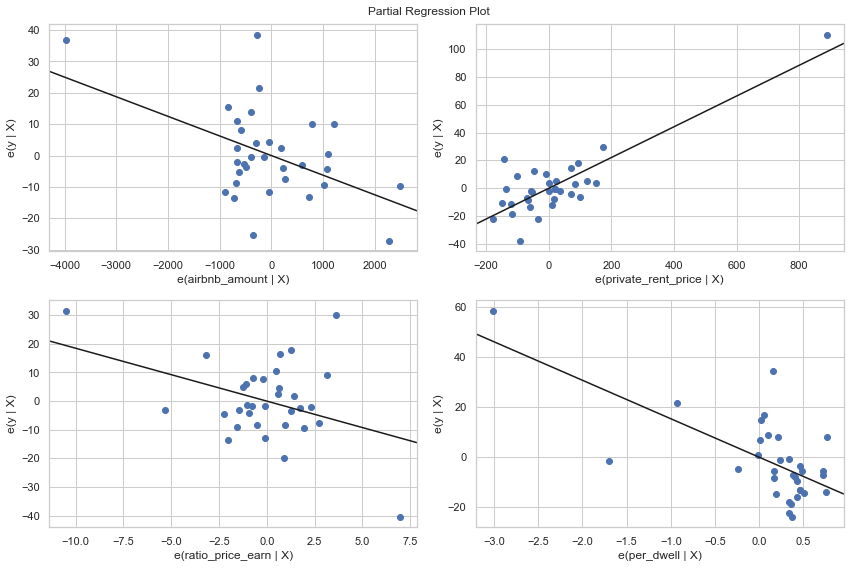

In [14]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

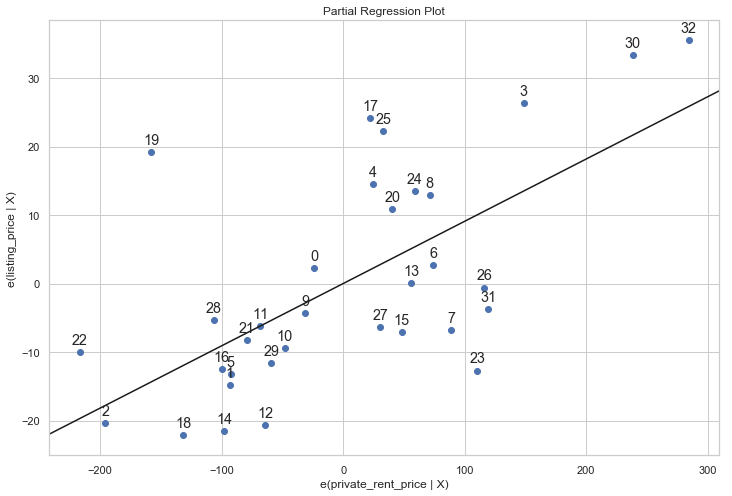

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress('listing_price', 'private_rent_price', ['airbnb_amount', 'ratio_price_earn', 'per_dwell'],  ax=ax, data=gdf)

### <a id='Influence Plots'>Influence Plots<a/>
Influence plots could be used to signify the influences on regression result from each row (borough for our data, and 33 in total).

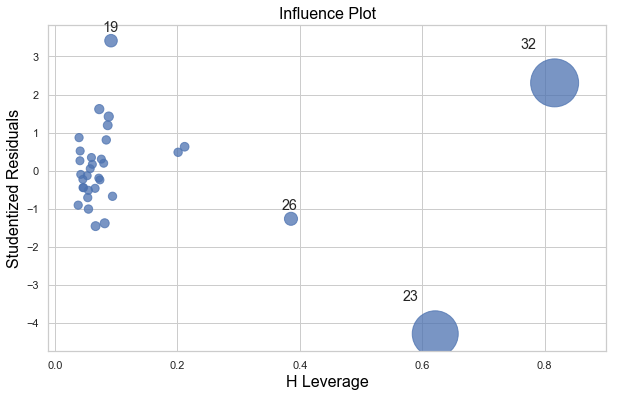

In [16]:
# visualize the influence from each borough
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model, ax=ax)

In [17]:
# Influence tests
from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(model)
test_class.dfbetas[:5,:]

array([[-0.03347319, -0.02010169,  0.03125878,  0.02867612],
       [ 0.01469872, -0.00445144,  0.01077253, -0.02400164],
       [-0.00795483, -0.02020806,  0.02411398,  0.02002529],
       [-0.11232535,  0.14171941, -0.16409333,  0.01999826],
       [-0.05512079, -0.009053  ,  0.02694248,  0.04605711]])

It will return a ndarray ($m*n$), where $m$ is the number you defined (here we give 5, but you may change it by yourself), $n$ is the number of independent variables (4 for our model), the value is studentized residuals.

### <a id='Leverage-Resid2 Plot'>Leverage-Resid2 Plot<a/>
Closely related to the influence_plot is the leverage-resid2 plot. Let's have a look of the leverage plot first. In order to interpret the diagnostic plot better, you are encourage to explore the [leverage](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression7.html).

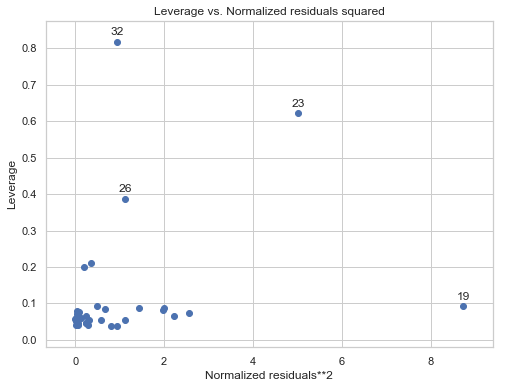

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_leverage_resid2(model, ax=ax)

The plot_regress_exog function is a convenience function that gives a 2x2 plot containing the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. This function can be used for quickly checking modeling assumptions with respect to a single regressor. Let's take the most significant variable "private_rent_price" as an example:

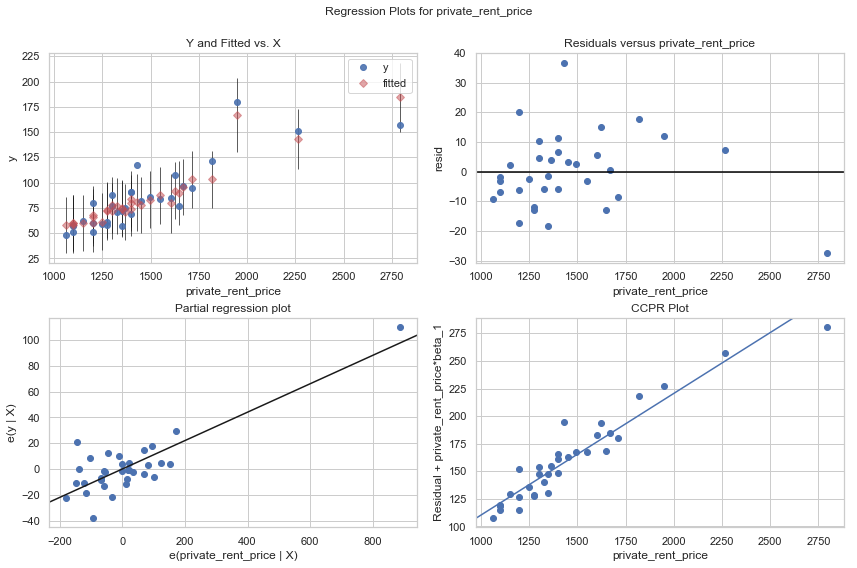

In [19]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'private_rent_price', fig=fig)

The plot_fit function plots the fitted values versus a chosen independent variable. It includes prediction confidence intervals and optionally plots the true dependent variable.

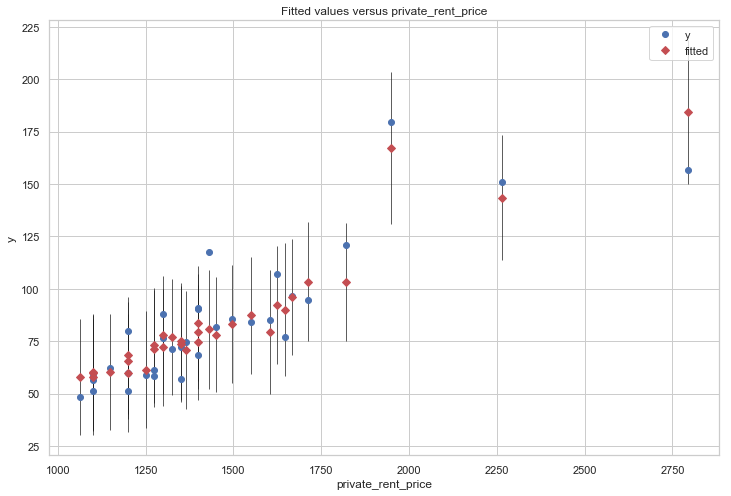

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "private_rent_price", ax=ax)

More functions to explore from `statsmodel` at http://www.statsmodels.org/stable/index.html.
## <a id='Spatial Regression'>Spatial Regression</a>
We need to use Moran's I tool to check for spatial autocorrelation firstly before conducting spatial regression.

In [22]:
w_queen = ps.weights.Queen.from_dataframe(gdf)

In [23]:
mi = ps.Moran(gdf['listing_price'], w_queen, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.4322 
The Expected Value for Statistic I is: -0.0312 
The Significance Test Value is: 0.0000


### <a id='Spatial Lag model'>Spatial Lag model</a>
In a similar way to how we have included the spatial lag, one could think the airbnb listing prices surrounding a given property also enter its own price function. Recall your memory on Spatial Lag model from lecture, and use `ML_Lag` class in `PySAL` to estimate this model.

In [24]:
sl = ml_lag.ML_Lag(y, X, w_queen, name_y='price', name_x=['number_of_reviews', 'private_rent','ratio_price_earning', 'person_dwelling'], name_w='w_queen', name_ds='borough_airbnb_housing')
print(sl.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :borough_airbnb_housing
Weights matrix      :     w_queen
Dependent Variable  :       price                Number of Observations:          33
Mean dependent var  :     84.0398                Number of Variables   :           6
S.D. dependent var  :     31.3432                Degrees of Freedom    :          27
Pseudo R-squared    :      0.8417
Spatial Pseudo R-squared:  0.8400
Sigma-square ML     :     150.814                Log likelihood        :    -129.646
S.E of regression   :      12.281                Akaike info criterion :     271.292
                                                 Schwarz criterion     :     280.271

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------

/anaconda3/envs/gsa2018/lib/python3.6/site-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


As we can see, results are again very similar in all the other variable. It is also very clear that the estimate of the spatial lag of price is statistically significant. This points to evidence that there are processes of spatial interaction between property owners when they set their price.

### <a id='Spatial Error model'>Spatial Error model</a>

In [25]:
se = ml_error.ML_Error(y, X, w_queen, name_y='price', name_x=['number_of_reviews', 'private_rent','ratio_price_earning', 'person_dwelling'], name_w='w_queen', name_ds='borough_airbnb_housing')
print(se.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :borough_airbnb_housing
Weights matrix      :     w_queen
Dependent Variable  :       price                Number of Observations:          33
Mean dependent var  :     84.0398                Number of Variables   :           5
S.D. dependent var  :     31.3432                Degrees of Freedom    :          28
Pseudo R-squared    :      0.8387
Sigma-square ML     :     151.974                Log likelihood        :    -129.774
S.E of regression   :      12.328                Akaike info criterion :     269.548
                                                 Schwarz criterion     :     277.030

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------

### <a id='Task 2'>Task 2</a>
Discuss you interpretation on the results from Spatial Lag Model and Spatial Error Model with your neighbors, comparing them with the OLS regression result last week, and summarize your conclusions below:

**----------------------------------------------------------------**

### <a id='Prediction performance of spatial models'>Prediction performance of spatial models</a>
We can use the mean squared error (MSE), a standard metric of accuracy in the machine learning literature, to evaluate whether explicitly spatial models are better than traditional, non-spatial ones:

In [26]:
m1 = ols.OLS(y, X, name_y = 'price', name_x = ['number_of_reviews', 'private_rent','ratio_price_earning', 'person_dwelling'], name_ds = 'borough_airbnb_housing')

In [27]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(y, m1.predy.flatten()), 
                  'SL': mse(y, sl.predy.flatten()), 
                  'SE': mse(y, se.predy.flatten())
                    })
mses.sort_values()

SL     150.813915
OLS    153.468454
SE     153.696911
dtype: float64

The inclusion of the spatial lag of price marginally reduces the MSE, however, does a better job at improving the accuracy of the model.

### <a id='GWR Prediction'>GWR Prediction</a>
Geographically weighted regression (**GWR**) can fit Gaussian, Poisson, and logistic models to estimate a 'GWR Results' object. Now let's compare the maps $before$ and $after$ applying the GWR prediction.

In [28]:
from pysal.contrib.gwr.sel_bw import Sel_BW
from pysal.contrib.gwr.gwr import GWR
from pysal.contrib.glm.family import Gaussian
from scipy.stats import pearsonr

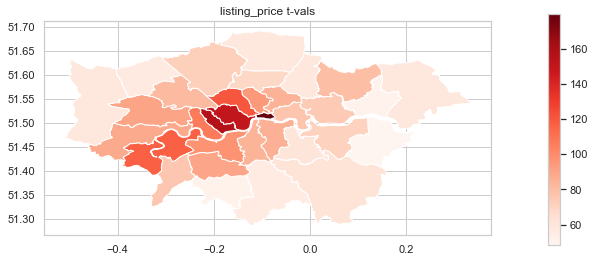

In [29]:
vmin, vmax = np.min(gdf['listing_price']), np.max(gdf['listing_price']) 
ax = gdf.plot('listing_price', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Reds')
ax.set_title('listing_price'+' t-vals')
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4]) # the position and size of colormap legend bar
sm_price = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')
sm_price._A = []
fig.colorbar(sm_price, cax=cax)

In [30]:
# Prep data into design matrix and coordinates

# Dependent variable
y = gdf.listing_price
y = np.array(y).reshape(-1,1) # make array change the list format

In [31]:
#Design matrix - covariates - intercept added automatically
amou = np.array(gdf.airbnb_amount).reshape(-1,1)
rent = np.array(gdf.private_rent_price).reshape(-1,1)
ratio = np.array(gdf.ratio_price_earn).reshape(-1,1)
pdwell = np.array(gdf.per_dwell).reshape(-1,1)

X = np.hstack([amou, rent, ratio, pdwell])
labels = ['Intercept', 'amount', 'rent', 'ratio', 'dwellresid']

# standardization
X_s = (X - X.mean(axis=0)) / X.std(axis=0)
y_s = (y - y.mean(axis=0)) / y.std(axis=0)

In [32]:
#Coordinates for calibration points

def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [33]:
#Find optimal bandwidth using golden section search to minimize AICc

#Instantiate bandwidth selection class - bisquare NN (adaptive)
selector = Sel_BW(coords, y_s, X_s, kernel='bisquare', fixed=False)

#Find optimal bandwidth by minimizing AICc using golden section search algorithm
bw = selector.search(search='golden_section', criterion='AICc')

print (bw)

59.0


In [34]:
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw, family=Gaussian(), fixed=False, kernel='bisquare')
results = model.fit()

In [35]:
#Results in a set of mappable results 
results.params.shape

(33, 5)

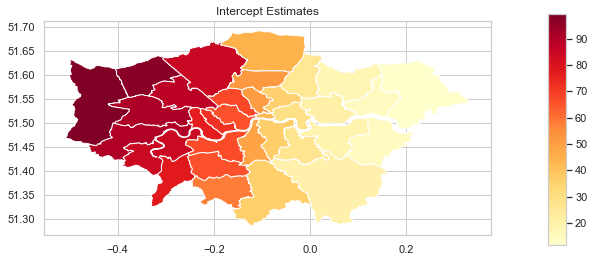

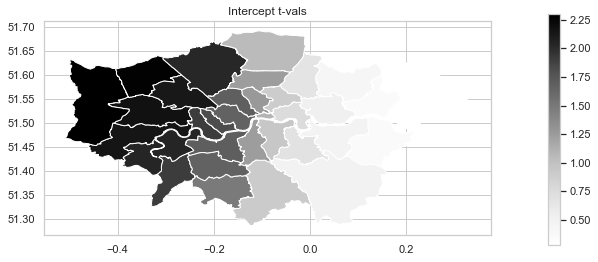

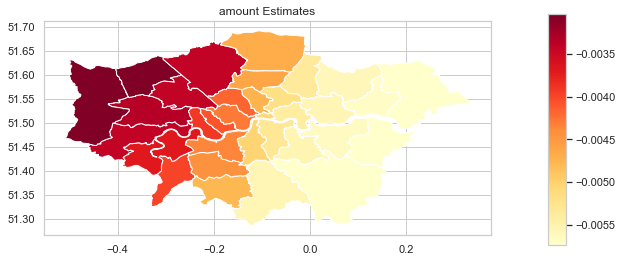

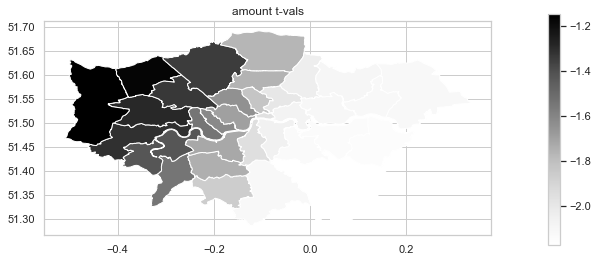

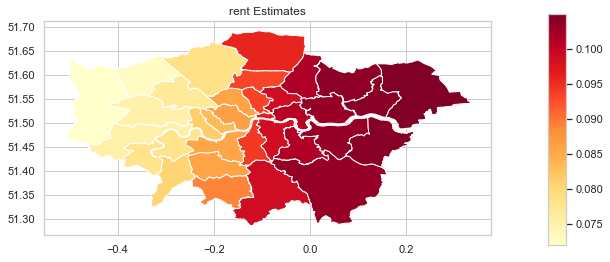

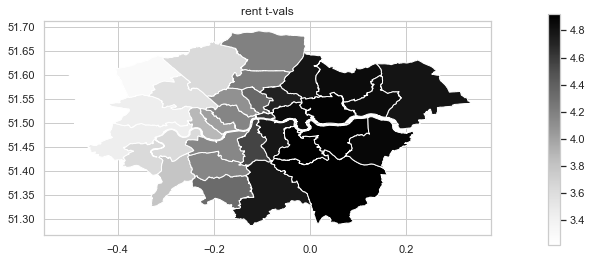

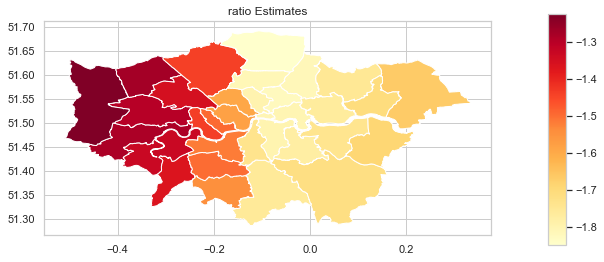

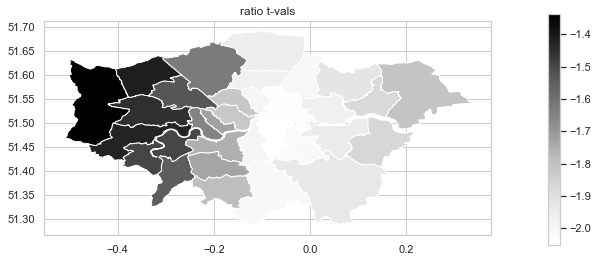

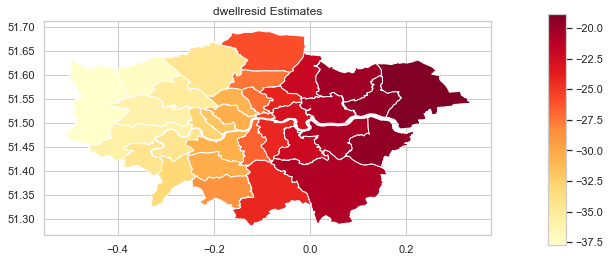

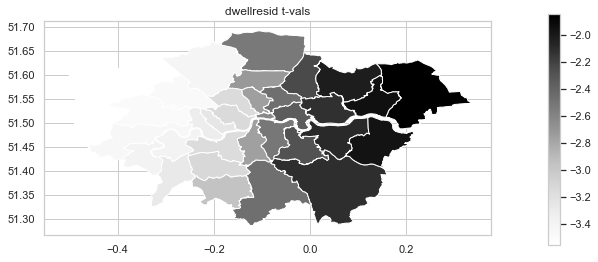

In [36]:
#Map Parameter estimates and T-vals for each covariate
for param in range(results.params.shape[1]):
    gdf[str(param)] = results.params[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    gdf[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    ax.set_title(labels[param] + ' t-vals')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)

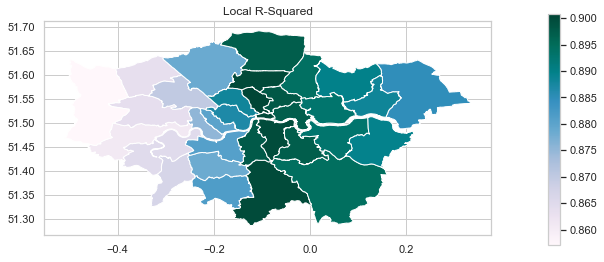

In [37]:
#Map local R-square values which is a weighted R-square at each observation location

gdf['localR2'] = results.localR2
vmin, vmax = np.min(gdf['localR2']), np.max(gdf['localR2']) 
ax = gdf.plot('localR2', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='PuBuGn')
ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='PuBuGn')
sm._A = []
fig.colorbar(sm, cax=cax)

# Credits！